In [1]:
%matplotlib inline

In [2]:
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
pd.options.mode.chained_assignment = None #default = 'warn'

sns.set(style="whitegrid")

# You may load the dataset from URL (instead of the local file) if you wish
auto_mpg_data = "https://raw.githubusercontent.com/fundamentals-of-data-science/datasets/master/auto-mpg.data.txt"
auto_mpg_names = "https://raw.githubusercontent.com/fundamentals-of-data-science/datasets/master/auto-mpg.names.txt"

# Problem Set 5.1

This Problem Set is a two parter. In the first part you will apply ETL/EDA/Mathematical Modeling (Labs 5 and 6) to a new data set.
Each part is a separate grade.
Take all your PS3 comments into account.

## Directions

1. Show all work/steps/calculations using a combination of code and Markdown.
2. **All** work is to be your own. This is not a group project. You may, however, use code from the lectures and labs. Provide citations for any code that is not your own. You may also consult Stackoverflow, etc. This is not by any means "closed book" or anything like that. Basically, I need to see if *you* learned the concepts from the Lectures, *Fundamentals*, and Labs.
3. Add whatever markdown or code cells you need in each part to explain and calculate your answers. Don't just provide answers but explain them as well. **Explain and interpret your results.**


<div style="background: lemonchiffon; margin:20px; padding: 20px;">
    <strong>Note</strong>
    <p>This part of the Problem Set covers Labs 5 and 6. You get even less help this time. You should just know what to do.</p>
    <p>Additionally, this is a <em>report</em>, a narrative description of your process and findings. Use full sentences. Limit bullet lists. You should be able to "hide code" and have the remaining text make sense.</p></div>

## 1.1 - ETL

Let's first start by taking a look at the data and names files we've read in. Since these are text files, I'm going to manually take a quick peek at these files.

From our names file, we have our attribute information for our data.

```
Description of fields in auto mpg data.

Name            Data Type
----            ---------
mpg             continuous
cylinders       multi-valued discrete
displacement    continuous
horsepower      continuous
weight          continuous
acceleration    continuous
model year      multi-valued discrete
origin          multi-valued discrete
car name        string (unique for each instance)
```

So we have 9 different variables in this dataset (most appear to be numeric). We know from our names file that there should be 398 instances/observations, and the $horsepower$ variable has 6 missing values.

We will cover these in more detail during the EDA process. For now let's try reading in the data. 

In [3]:
auto_mpg_data

'https://raw.githubusercontent.com/fundamentals-of-data-science/datasets/master/auto-mpg.data.txt'

This is indeed a text file with some data in it. Our first step should be getting our data into tidy data. Since there is an inconsistent amount of whitespace between each entry for any particular observation, we can tell our `pd.read_csv()` method to consider any whitespace between a value as a separator. (I initially used the `delim_whitespace=True` parameter, though that seems to be depreciated in favor of `\s+` now).

Since there are no headers in this text file, I will manually add the columns to our dataframe, using the description that we found above in our names file.

In [4]:
columns = [
    'mpg', 
    'cylinders', 
    'displacement', 
    'horsepower',
    'weight', 
    'acceleration', 
    'model year',
    'origin', 
    'car name'
]

data = pd.read_csv(auto_mpg_data, sep='\s+', header=None, names=columns)

We'll check the first few entries to make sure our data has been read in properly.

In [5]:
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


Looks like we got most of what we need. We have 9 columns to represent each feature/attribute. We can also look at the information provided here with the `info()` method.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB


We do in fact see 398 rows for each attribute. Most variables are floats or integers, with the exceptions of $horsepower$ and $car name$, the latter which we expect to be strings, so this is not unexpected. But we know $horsepower$ has 6 missing values somewhere. How should we handle this? I'm going to simply look at our observations first, where $horsepower$ does not have a value (from peeking at the data text file, I know the missing values are coded as a '?').

In [7]:
data[data['horsepower'] == '?']

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
32,25.0,4,98.0,?,2046.0,19.0,71,1,ford pinto
126,21.0,6,200.0,?,2875.0,17.0,74,1,ford maverick
330,40.9,4,85.0,?,1835.0,17.3,80,2,renault lecar deluxe
336,23.6,4,140.0,?,2905.0,14.3,80,1,ford mustang cobra
354,34.5,4,100.0,?,2320.0,15.8,81,2,renault 18i
374,23.0,4,151.0,?,3035.0,20.5,82,1,amc concord dl


We do in fact only have 6 observations here. Because that's only (6/398) = 0.015, or about 1.5% of our data, I will consider imputation for these 6 values with the median of $horsepower$. Note I'm choosing to use median instead of the mean since the median is a more robust statistic. This should not create inliers or other data abnormalities such as loss of variation since there are only a small number of missing values. We might turn to some domain knowledge to think about whether our median is a good estimate for these missing values.

[Average Horsepower of a Car Over the Years](https://carbuzz.com/features/average-horsepower-of-a-car-over-the-years/)

In this article, we get different ranges for the average horsepower of cars in the United States, mostly broken down by decade. To summarize, the 50s started out with an average of about 100 horsepower, and only went up to about 120hp by the 80s. Later decades saw a bit of increase, where the average could be considered closer to 175hp or so, but this might at least give us an idea if we're on the mark with imputing our missing values.

I know this is kind of blending into the EDA portion a bit, so I will just replace the missing values with our median here, and as long as we have our tidy data, we can start the EDA process and go more in depth with horsepower in the next section.

We need to select all the other 392 rows that don't include the 6 missing values in order to get the median for $horsepower$.

In [8]:
data_no_missing = data[data['horsepower'] != '?']

Since the $horsepower$ variable was a mix of strings and floats, it caused all the values to become strings. We fix this below so we can perform the numpy operations on this column.

In [9]:
data_no_missing['horsepower'] = data_no_missing['horsepower'].astype('float64')

Here we can finally find the median of $horsepower$ without the missing values. 

In [10]:
np.median(data_no_missing['horsepower'])

93.5

It's 93.5, which seems like a reasonable guess for our missing values, if not slightly on the low side, remembering that we theorized average car horsepowers range between 100-200, very roughly. (Again, we could also look at the median model years for the cars to get a better rough estimate, but I think that's getting too much into the EDA portion of things).

Finally, we can replace our missing values with our median of 93.5 and convert the column into a float type to prepare for our EDA.

In [11]:
data = data.replace('?', '93.5')
data['horsepower'] = data['horsepower'].astype('float64')

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    float64
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(5), int64(3), object(1)
memory usage: 28.1+ KB


We can see that our $horsepower$ variable is now a float64 type instead of object like it was originally. We are ready to move on to EDA now.

## 1.2 - EDA


For our EDA, we'll start with single variable EDA and just go down the list, followed by pairwise EDA with our target variable ($mpg$). First up for single variable EDA is $mpg$.

Before we start, we might guess as to how each variable could affect $mpg$ similar to a causal loop diagram. I don't want to focus on the diagram here, but I'll list out some relationships that might be important, based on my own domain knowledge.

<ul>
    <li>cylinders -> (-) mpg: more cylinders generally means higher fuel usage and thus less efficient mpg.
    <li>horsepower -> (-) mpg: similar to cylinders, higher horsepower generally means more fuel usage, so we might expect cars with high horsepower to have lower values of mpg.
    <li>cylinders -> (+) horsepower: on that note, more cylinders typically means more power/horsepower, so we would expect a positive relationship here.
    <li>model year -> (+) mpg: newer cars typically have better mileage than older ones.
<ul>

Of course there are more relationships that are unexplored here, but I think this is enough to get us started. Note I am copying the `freeman_diaconis`, `histogram_w_whiskers`, and `histogram_trio` functions from the `eda.py` file for use below.

In [13]:
def freeman_diaconis(data):
    quartiles = stats.mstats.mquantiles( data, [0.25, 0.5, 0.75])
    iqr = quartiles[2] - quartiles[ 0]
    n = len( data)
    h = 2.0 * (iqr/n**(1.0/3.0))
    #error handling for int rounding down to 0
    if h < 1:
        return 1
    return int( h)

In [14]:
def histogram_w_whiskers(data, variable_name, zoom=None):
    h = freeman_diaconis(data[variable_name])
    mn = int(data[variable_name].min())
    mx = int(data[variable_name].max())
    bins = [i for i in range( mn, mx, h)]
    print(f"Freeman Diaconis for {variable_name}: {len(bins)} bins")

    observations = len(data)
    empirical_weights = np.ones(observations)/observations # this converts counts to relative frequencies when used in hist()
        
    # start the plot: 2 rows, because we want the boxplot on the first row
    # and the hist on the second
    fig, ax = plt.subplots(
        2, figsize=(7, 5), sharex=True,
        gridspec_kw={"height_ratios": (.7, .3)}  # the boxplot gets 30% of the vertical space
    )

    # the histogram
    ax[0].hist(data[variable_name],bins=bins, color="dimgray", weights=empirical_weights)
    ax[0].set_title(f"{variable_name} distribution - Freeman Diaconis")
    ax[0].set_ylabel("Relative Frequency")
    if zoom:
        ax[0].set_ylim((0, zoom))
    # the box plot
    ax[1].boxplot(data[variable_name], vert=False)
    # removing borders
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['left'].set_visible(False)
    ax[1].set_xlabel(variable_name)

    # and we are good to go
    plt.show()
    plt.close()
    return h

In [15]:
def histogram_trio(data, variable_name, zoom=1.0):
    h = freeman_diaconis(data[variable_name])
    mn = int(data[variable_name].min())
    mx = int(data[variable_name].max())
    bins = [i for i in range( mn, mx, h)]
    print(f"Freeman Diaconis for {variable_name}: {len(bins)} bins")

    observations = len(data)
    empirical_weights = np.ones(observations)/observations # this converts counts to relative frequencies when used in hist()

    fig, ax = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

    fewer_bins = int(len(bins) * .50)
    more_bins = int(len(bins) * 2)

    n, bins, patches = ax[1].hist(data[variable_name], color="DimGray", bins=bins, weights=empirical_weights) # <---
    ax[1].set_xlabel(variable_name)
    ax[1].set_ylabel("Relative Frequency")
    ax[1].set_title(f"Relative Frequency Histogram of {variable_name}")
    ax[1].set_ylim((0, zoom))
    
    n, bins, patches = ax[0].hist(data[variable_name], color="DimGray", bins=fewer_bins, weights=empirical_weights)
    ax[0].set_xlabel(variable_name)
    ax[0].set_ylabel("Relative Frequency")
    ax[0].set_title(f"Relative Frequency Histogram of {variable_name} (Fewer Bins)")
    
    n, bins, patches = ax[2].hist(data[variable_name], color="DimGray", bins=more_bins, weights=empirical_weights)
    ax[2].set_xlabel(variable_name)
    ax[2].set_ylabel("Relative Frequency")
    ax[2].set_title(f"Relative Frequency Histogram of {variable_name} (More Bins)")

    plt.show()
    plt.close()

### $Miles \ Per \ Gallon \ (MPG)$

$mpg$ is our target variable. As such, we will see a lot relationships between mpg and the others during our pairwise analysis. This is a numeric variable and as such, we can find descriptive statistics for it. Typical fuel economy of cars can range from 10 mpg for larger cars like SUVs to about 30 mpg for more mid-sized cars. My car, which is considered more fuel efficient, gets closer to 30 mpg, so I imagine that's a bit higher than average.

[Fuel Economy in Automobiles](https://en.wikipedia.org/wiki/Fuel_economy_in_automobiles#:~:text=An%20average%20North%20American%20mid,L%2F100%20km)

In [16]:
data['mpg'].describe()

count    398.000000
mean      23.514573
std        7.815984
min        9.000000
25%       17.500000
50%       23.000000
75%       29.000000
max       46.600000
Name: mpg, dtype: float64

We have an average of about 23.5, with a standard deviation of 7.8, fairly relatively large. The min is 9 while the max is a whopping 46.6. As the 3rd quartile is only 29, we would expect the max to be an outlier. The median is 23. As such, we expect to see a fairly symmetric histogram being so close to the mean.

Let's create a histogram and boxplot to visualize the data.

Freeman Diaconis for mpg: 13 bins


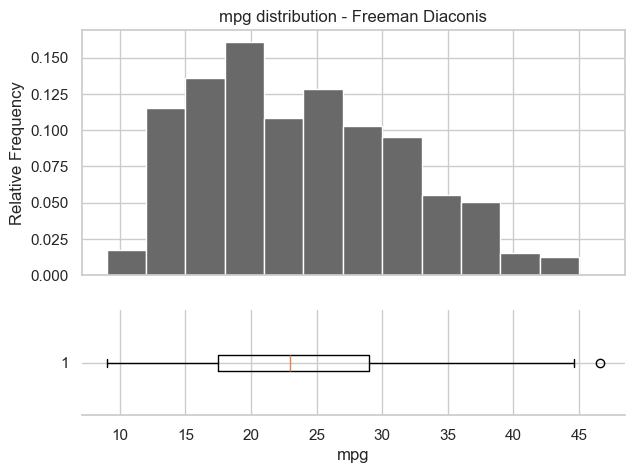

3

In [17]:
histogram_w_whiskers(data, 'mpg')

Looks like the tiniest bit of right skew, though otherwise symmetric as we predicted. We do see the max as an extreme value on the boxplot with whiskers, while it seems that most values are contained within the 'whiskers' (Q1 - 1.5 x IQR, Q3 + 1.5 x IQR). We can also try changing the bin size of the histogram to see if any patterns emerge, but I predict we won't see anything too unusual.

Freeman Diaconis for mpg: 13 bins


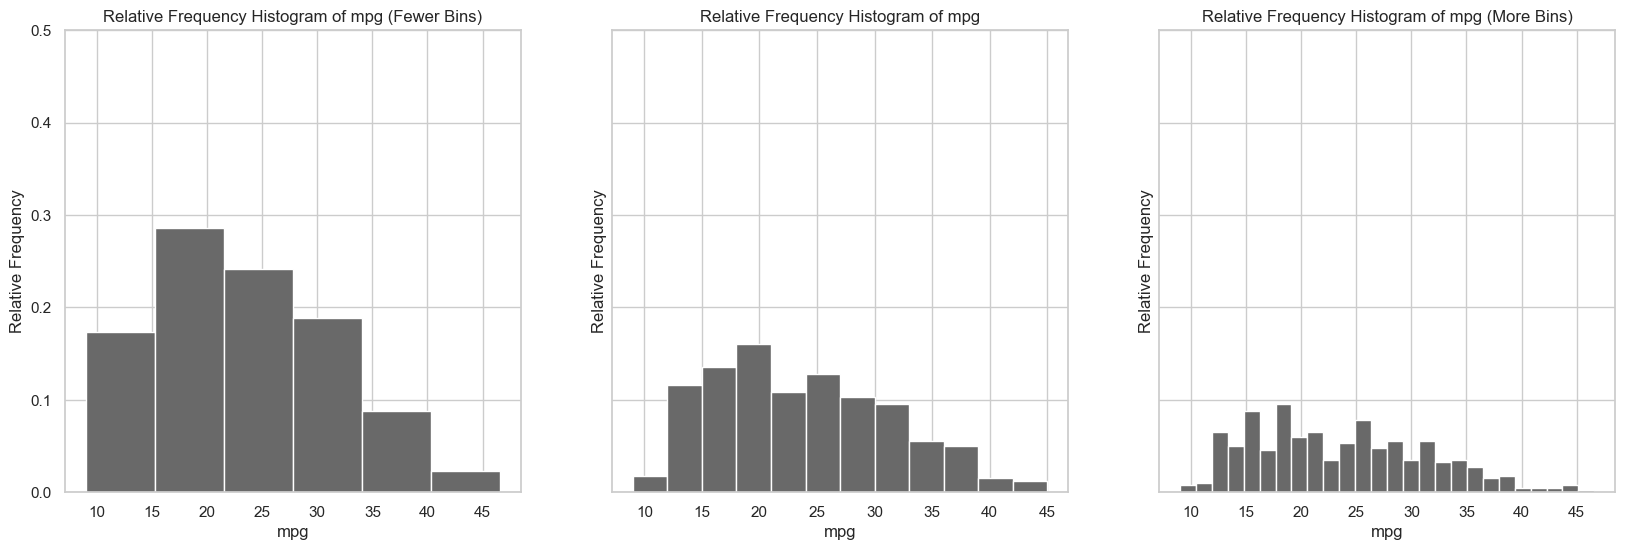

In [20]:
histogram_trio(data, 'mpg', zoom=0.5)

There seems to be a bit of a drop off as we go from about 12-13 down to 11 or so, which is a bit more evident with more bins. Other than that, we see almost a cyclic pattern with the more bins, which I wonder if it's simply because it is too many bins for this variable (remember that the range is not that large).

Since this is our target I won't spend too much time with takeaways here, but maybe there is another factor that explains the cyclic pattern in the histogram with more bins.

### $Cylinders$

Now we look at cylinders. This represents how many cylinders the car's enginer has. This is also a numeric variable, though it is discrete, not continuous. I believe the most common cylinder types are 4 and 6, so I expect to see a large frequency of those values. As mentioned above, typically more cylinders leads to increased fuel usage and thus less efficient gas mileage. Here are the summary statistics:

In [21]:
data['cylinders'].describe()

count    398.000000
mean       5.454774
std        1.701004
min        3.000000
25%        4.000000
50%        4.000000
75%        8.000000
max        8.000000
Name: cylinders, dtype: float64

We see a mean of 5.45 and standard deviation of 1.7. The 3rd quartile and the max are both 8, while the 1st quartile and median are both 4. Let's look at the value counts to see how many different values for $cylinders$ we actually have.

In [23]:
data['cylinders'].value_counts().sort_index()

cylinders
3      4
4    204
5      3
6     84
8    103
Name: count, dtype: int64

The most common cylinder type is 4, while the second most is 8, by about half. 6 is not too far behind in third, and then only a few results for 3 and 5 cylinders.

Because this variable only has a few possibilities and is also a count variable, I'm going to treat this as an ordered categorical variable for charts (I don't think it makes sense for a histogram here, for example.) Apparently there are some cars that do have 3 and 5 cylinder engines, so we should still consider those valid entries.

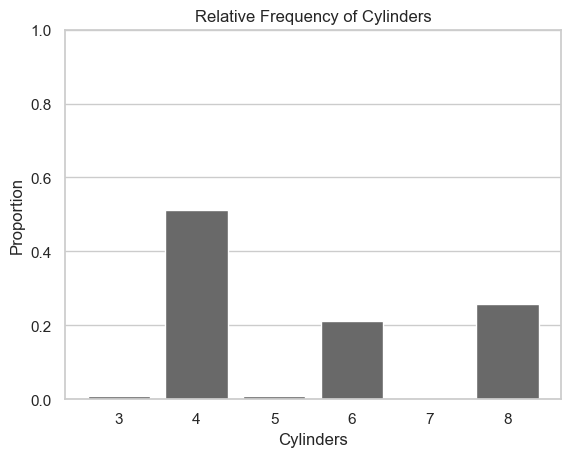

In [40]:
counts = data['cylinders'].value_counts().sort_index()
proportions = data['cylinders'].value_counts(normalize=True).sort_index()
x = sorted(data['cylinders'].unique())

plt.bar(x, proportions, color='dimgray')
plt.ylim((0, 1))
plt.grid(axis='x')

plt.xlabel('Cylinders')
plt.ylabel('Proportion')
plt.title('Relative Frequency of Cylinders')

plt.show()
plt.close()


Nothing unusual here - just a visualization of the value count results we found above. It is clear that 4 is the most common cylinder type, about half of the data consistents of 4 cylinder cars. 8 and 6 cylinders are a bit less common around 25 and 20 percent, respectively, and again only a few values for 3 and 5 cylinders.

1. More cylinders typically corresponds to higher power, so we suspect an increase in cylinders leads to an increase in horsepower

2. This horsepower increase leads to lower fuel mileage, so we might see similar patterns between $cylinders$ and $mpg$ as we do between $horsepower$ and $mpg$ for pairwise analysis

### $Displacement$

Next we have displacement, which is commonly used as an expression of an engine's size. It could also be indicative of power, though these days it's common for car manufacturer's to downsize engines and use powerboosters and other pieces to provide higher horsepower for a car's output.

[Engine Displacement](https://en.wikipedia.org/wiki/Engine_displacement) <br>
[What is Engine Displacement and Why Does it Matter?](https://www.capitalone.com/cars/learn/finding-the-right-car/what-is-engine-displacement-and-does-it-matter/2055)

From our domain knowledge, there is actually an equation to calculate displacement, which is dependent on cylinders:

$Displacement = stroke \ length * \pi (\frac{bore}{2})^2 * cylinders$

Where:
```
stroke length = cylinder height
bore = diameter of the hole drilled into engine block to accept a piston
cylinder = number of cylinders
```




$Displacement$ is a continuous numeric variable, so we can look at some summary statistics. We expect higher displacement values to correspond to higher horsepower and more fuel consumption, and this lower mileage.

In [41]:
data['displacement'].describe()

count    398.000000
mean     193.425879
std      104.269838
min       68.000000
25%      104.250000
50%      148.500000
75%      262.000000
max      455.000000
Name: displacement, dtype: float64

We see a mean of 193.4, but a median of only 148.5, indicating a right skew in the data. The standard deviation is large at 104.3. The min of 68 to the 1st quartile of 104.3 and 1st quartile to median are pretty evenly spaced. The median to 3rd quartile of 262 and 3rd quartile to max of 455 are not so much. We should expect to see a lot of large values in the histogram.

Freeman Diaconis for displacement: 9 bins


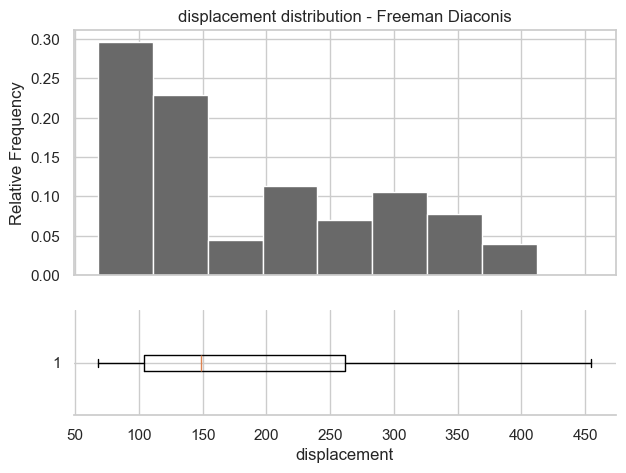

43

In [42]:
histogram_w_whiskers(data, 'displacement')

Because the interquartile range is so large, the boxplot does not show any extreme values. We do in fact see a strongly right skewed histogram, though the most common values seem to lie below the median. Let's try a histogram trio to see if changing bin size shows any interesting properties.

Freeman Diaconis for displacement: 9 bins


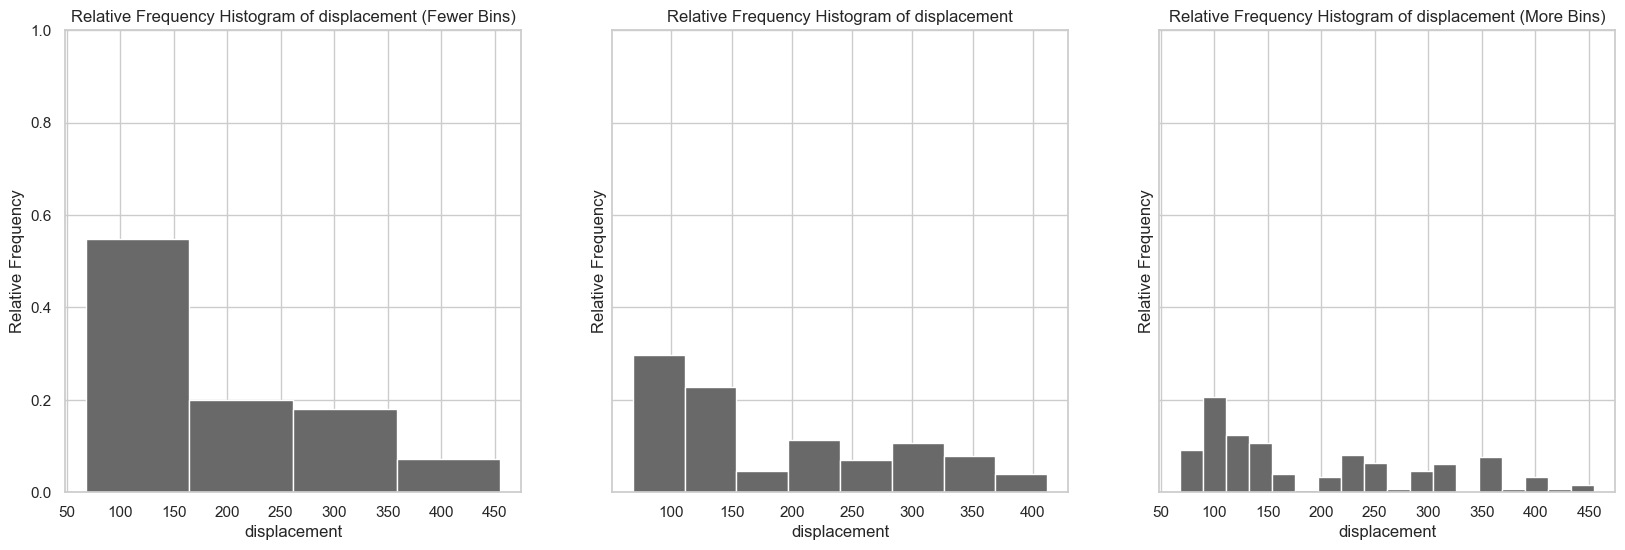

In [43]:
histogram_trio(data, 'displacement')

With more bins we see sort of a 'jumping' pattern - no values for certain ranges between some of the larger values, for example 250-300.

1. As mentioned, displacement is dependent on cylinders, which we know only have a few discrete values, so there are other factors to consider that we have no data for.

2. While this variable is continuous, we have to remember that auto makers likely have certain standards of quality control and tolerances for their manufacturing processes, so similar cars could have similar values of $displacement$.

### $Horsepower$

Here we have horsepower, which basically describes how much rapidly a car's enginer can work / work output. According to this article:

[What is the Average Horsepower of a Car?](https://www.jdpower.com/cars/shopping-guides/what-is-the-average-horsepower-of-a-car)

The average horsepower for standard vehicles lies in the range of 180-200 horsepower. Whereas smaller cars might have closer to 100 horsepower, larger automobiles could see this as high as 300.

Like $displacement$, this is a continuous numeric variable, and so we can look at the summary statisticss. We expect most of the values to lie between 100-300, but apparently some engines can get up to 1,200 or so horsepower.

In [44]:
data['horsepower'].describe()

count    398.000000
mean     104.304020
std       38.222625
min       46.000000
25%       76.000000
50%       93.500000
75%      125.000000
max      230.000000
Name: horsepower, dtype: float64

The mean is 104 with a slightly lower median of 93.5 (which we knew from our ETL). The standard deviation is a good chunk of change at 38. The min is 46, and the max 230, a bit lower than we predicted. The 3rd quartile is only 125, so we might expect the max to be an extreme value for this dataset.

Let's look at a histogram and boxplot. We expect the histogram to show a right skew since median is less than the mean.

Freeman Diaconis for horsepower: 15 bins


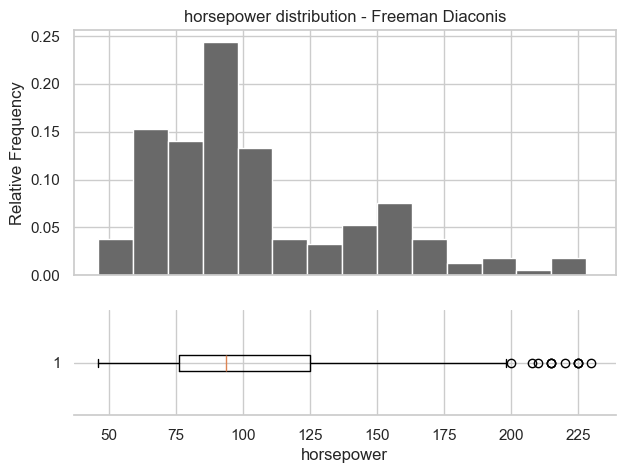

13

In [45]:
histogram_w_whiskers(data, 'horsepower')

We do see a right skewed histogram, with several extreme values between 200 and the max of 230. Let's also check different bin sizes of the histogram

Freeman Diaconis for horsepower: 15 bins


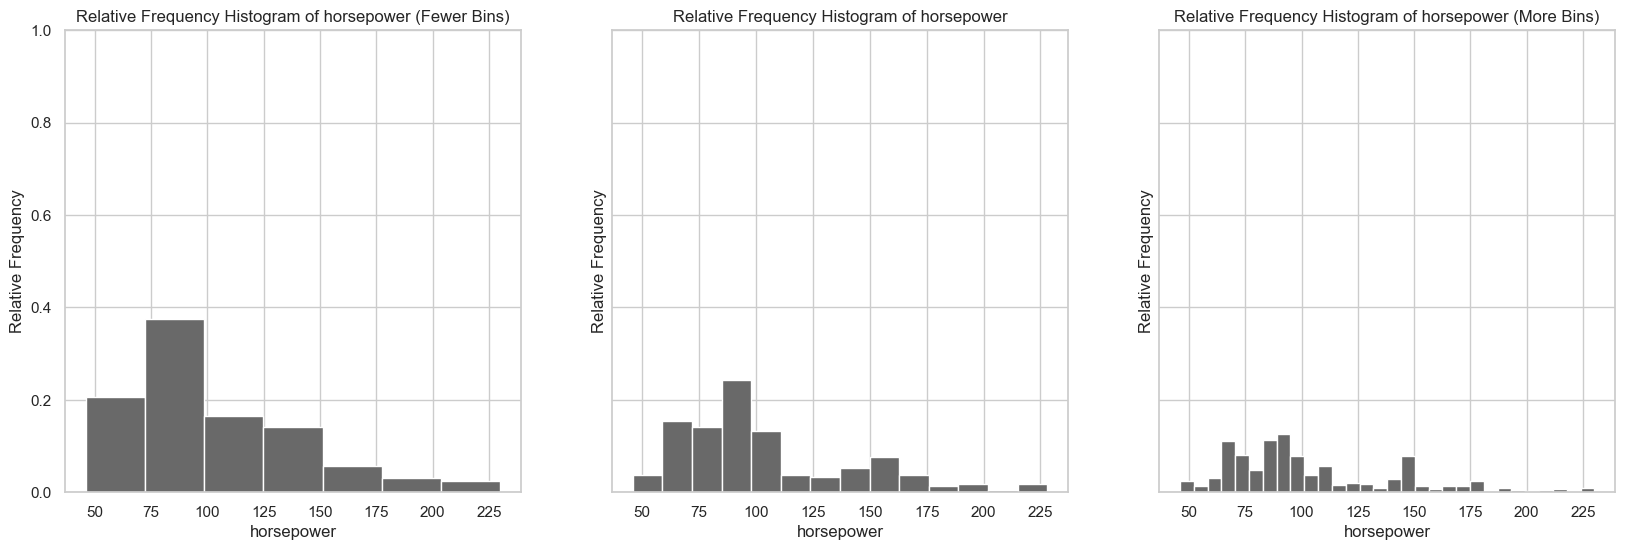

In [46]:
histogram_trio(data, 'horsepower')

I don't see any unusual patterns emerging here. I think each of these histograms tells the same story.

1. From our pseudo causal loop diagram, we expect $horsepower$ and $mpg$ to be negatively correlated.

2. $Horsepower$ and $cylinders$ are likely to be positively correlated. Both intend to increase fuel consumption and might lead to lower $mpg$.

## 1.3 - Null & Distributional Models

---

**PRE-SUBMISSION CHECK LIST**

Before you submit this assignent, go back and review the directions to ensure that you have followed each instruction.

* [ ] Have you completed every section and answered every question asked?
* [ ] For every question, have you described your approach and explained your results?
* [ ] Have you checked for spelling and grammar errors?
* [ ] Are your code blocks free of any errors?
* [ ] Have you deleted unused code or markdown blocks? Removed scratch calculations? Excessive raw data print outs?
* [ ] Hide all the code/output cells and make sure that you have sufficient discussion. Re-show the output cells but leave code cells hidden.
* [ ] Have you *SAVED* your notebook?
* [ ] Are you following the submission requirements for this particular assignment?